# 0. 项目初始化

In [ ]:
# 克隆仓库
! git init
! git clone https://github.com/atong01/conditional-flow-matching

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /kaggle/working/.git/
Cloning into 'conditional-flow-matching'...
remote: Enumerating objects: 2195, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 2195 (delta 390), reused 309 (delta 309), pack-reused 1665 (from 2)
Receiving objects: 100% (2195/2195), 142.73 MiB | 20.72 MiB/s, done.
Resolving deltas: 100% (1268/1268), done.


In [2]:
cd conditional-flow-matching

/kaggle/working/conditional-flow-matching


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 

# 1. 小批量最优传输惊人的优异表现

## 在推理时构建直线流

在本笔记中，我们将深入分析基于最优传输（OT）、小批量最优传输和熵正则化最优传输生成的OT-CFM流，重点关注*8高斯分布到双月形分布*的任务。对于需要全面了解流匹配教程的读者，建议参考我们专门的流匹配教程笔记。

流匹配依赖于从潜在分布$q$中提取的条件变量$z$。对于$q$的选择有多种可能，一个自然的选择是采用均匀分布。在我们的OT-CFM和SB-CFM方法中，我们将$q$定义为最优传输方案。形式上，我们的变量$z$是源变量和目标变量组成的元组，这些变量从OT方案$\pi$中抽取（即$(x_0, x_1) \sim \pi$）。该方案$\pi$可以来源于最优传输的解，或小批量最优传输，或熵正则化最优传输。本笔记致力于探索使用不同最优传输方案带来的影响。

本笔记中介绍的流匹配方法基于论文[OT-CFM](https://arxiv.org/abs/2302.00482)。关于小批量OT（OT-CFM所使用的方法）的理论和实践研究可以在论文[Learning with minibatch Wasserstein](https://proceedings.mlr.press/v108/fatras20a.html)和[Minibatch optimal transport distances; analysis and applications](https://arxiv.org/abs/2101.01792)中找到。


In [4]:
import math
import os
import time

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import ot
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.optimal_transport import OTPlanSampler
from torchcfm.utils import *

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

2025-11-06 03:28:41.182294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762399721.367913      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762399721.415375      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

# 2. 最优传输

为了生成新样本，我们的OT-CFM方法依赖于最优传输理论。为简明起见，我们首先回顾在《流匹配教程》笔记中介绍的最优传输定义。

为获得更笔直的路径，我们可以利用最优传输理论。实际上，如[(Peyré et al., chapter 7)](https://arxiv.org/abs/1803.00567)所述，最优传输问题可以重新表述为最小路径长度问题。因此，我们希望利用这一特性来生成更笔直的流，从而实现更快的推理过程。

最优传输问题旨在最小化两个分布间的位移成本。形式上，令$\alpha = \frac1n \sum_{i=1}^n \delta_{x_i}$和$\beta = \frac1n \sum_{j=1}^n \delta_{z_j}$分别表示源分布和目标分布（即它们是狄拉克函数的加权和）。

最优传输基于两个核心概念：$\textbf{传输方案}$和$\textbf{成本函数}$。让我们深入探讨第一个概念。

为了将一个分布传输到另一个分布，我们考察它们的概率表示。分布$\alpha$和$\beta$是具有均匀权重的狄拉克函数和，这意味着我们可以将它们表示为位置和概率权重的元组（即$(x_i, \frac1n)_{i=1}^n$和$(z_j, \frac1n)_{j=1}^n$）。要将$\alpha$移动到$\beta$，需要将每个样本质量$\frac1n$从$\alpha$传输到$\beta$。

为形式化这一概念，我们引入传输矩阵$\Pi$。该矩阵的每一行对应一个源样本，每一列对应一个目标样本。因此元素$\Pi_{ij}$表示从$x_i$传输到$z_j$的质量量。

为确保每个$\alpha$样本都被传输到$\beta$（反之亦然），传输方案$\Pi$必须满足以下约束：$\sum_j \Pi_{ij} = a_i = \frac1n$且$\sum_i \Pi_{ij} = b_j = \frac1n$。这意味着每个样本的质量$\frac1n$都被移动到另一个分布。这些约束保证了传输过程中的质量守恒。

在建立分布传输方法后，让我们深入理解$\textbf{位移成本}$的概念。

在旨在最小化从$\alpha$到$\beta$距离成本的最优传输中，我们需要距离度量。因此我们评估源分布和目标分布支撑集之间的距离（即$\alpha$的$(x_i)_{i=1}^n$和$\beta$的$(z_j)_{j=1}^n$）。这需要引入基础成本矩阵$C$，其中$C_{ij} = \|x_i - z_j\|$用于度量支撑点$x_i$和$z_j$之间的距离。

整合所有组件，将$\alpha$移动到$\beta$的成本由$\sum_{ij} \Pi_{ij} C_{ij} = \langle \Pi, C \rangle_F$给出。

由于最优传输问题寻求最小位移成本，我们求解以下问题：$$\Pi^\star=\text{argmin}_{\Pi \in U(\alpha, \beta)} \langle \Pi, C \rangle.$$

其中$U(\alpha, \beta)$表示满足质量守恒约束的可行传输方案集合。

正因如此，为加速推理过程，**我们选择潜在分布$q(x_0, x_1) = \Pi(x_0, x_1)$.**

In [5]:
total_sample = 1000
# We fix the source and the target distributions for all the examples
x0 = sample_8gaussians(total_sample)
x1 = sample_moons(total_sample)

# We pre-compute the ground cost matrix
M = torch.cdist(x0, x1) ** 2

ot_plan_list = []
num_iter = 20000
a, b = ot.unif(total_sample), ot.unif(total_sample)

ot_sampler = OTPlanSampler(method="exact")
pi = ot_sampler.get_map(x0, x1)
ot_plan_list.append(pi)

/usr/local/lib/python3.11/dist-packages/ot/lp/_network_simplex.py:332: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


# 3.基于小批量最优传输的OT-CFM扩展方法

然而，传统最优传输的计算成本随样本数量呈三次方增长。因此，我们无法直接将其应用于大型数据集，而需要借助小批量最优传输近似方法来训练OT-CFM模型。

小批量最优传输的核心思想非常直观：不再计算完整分布之间的最优传输，而是在源样本和目标样本的小批量之间进行计算。从形式上说，在每次训练迭代中，我们均匀随机抽取一个源小批量和一个目标小批量，并计算它们之间的最优传输问题。但这种实践策略引入了小批量间最优传输问题的期望，从而*改变了原始的最优传输问题*，因为传输不再在完整分布之间计算。这种改变会带来理论上的缺陷，其中最显著的是小批量最优传输不再构成分布间的距离（参见[Fatras等，2020]的命题3）。我们建议读者参考以下文献以获取关于小批量最优传输的完整研究：[小批量Wasserstein学习](https://proceedings.mlr.press/v108/fatras20a.html)和[小批量最优传输距离：分析与应用](https://arxiv.org/abs/2101.01792)。

## 3.1 构建小批量分布

我们首先回顾源分布 $\alpha = \frac1n \sum_{i=1}^n \delta_{x_i}$ 和目标分布 $\beta = \frac1n \sum_{j=1}^n \delta_{z_j}$。由于我们需要求解小批量最优传输问题，因此需要理解完整分布 $\alpha$ 和 $\beta$ 之间的传输方案会发生什么变化。考虑到最优传输问题的输入是样本分布，我们需要建立小批量的分布表示。

为实现这一目标，令 $I = \{i_1, \cdots, i_m \}$（对应地 $J= \{j_1, \cdots, j_m \}$）表示用于抽取源（对应目标）小批量的索引 $m$ 元组。与元组 $I$ 和 $J$ 关联的源和目标小批量分布定义为 $\alpha_I = \frac1m \sum_{i=i_1}^{i_m}\delta_{x_i}$ 和 $\beta_J = \frac1m \sum_{j=j_1}^{j_m} \delta_{z_j}$。值得注意的是，这些分布是规模为 $m$ 的均匀分布——这是确保整个 $\alpha$ 和 $\beta$ 分布最终被传输的关键要素。因此，我们的目标是求解小批量最优传输问题 $OT(\alpha_I, \beta_J)$。实际应用中，小批量通过均匀随机抽样获得，如下列函数所示：

In [6]:
def mini_batch(data, batch_size):
    """
    Select a subset of sample space according to measure
    with np.random.choice

    Parameters
    ----------
    - data : ndarray(N, d)
    - batch_size : int
        batch size 'm'

    Returns
    -------
    - minibatch : ndarray(ns, nt)
        minibatch of samples
    - sub_weights : ndarray(m,)
        distribution weights of the minibatch
    - id_batch : ndarray(N_data,)
        index of minibatch elements
    """
    id_ = np.random.choice(np.shape(data)[0], batch_size, replace=False)
    sub_weights = ot.unif(batch_size)
    return data[id_], sub_weights, id_

## 3.2 构建小批量最优传输矩阵

对于每一组索引对 $I = (i_1,\ldots,i_m)$ 和 $J = (j_1,\ldots,j_m)$，定义小批量间的基础成本矩阵 $C_{I, J} = (\|x_i - z_j\|^2)_{i_1 \leq i \leq i_m, j_1 \leq j \leq j_m}$。$\alpha_I$ 与 $\beta_J$ 之间的小批量最优传输问题定义为 $\operatorname{OT}(\alpha_I, \beta_J) = \operatorname{min}_{\Pi \in U(\alpha_I, \beta_j)}\langle \Pi, C_{I,J} \rangle_F$。因此，传输方案（记为 $\Pi_{I,J}$）是一个 $m \times m$ 矩阵，它可以被提升为一个 $n \times n$ 矩阵，其中除 $I \times J$ 索引对应的元素外其余全为零：

$
\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \Pi_{I,J}^n =  \left\{
    \begin{array}{ll}
        0 & \text{若 $i$（对应地 $j$）不在 $I$（对应地 $J$）中}\\
        \Pi_{i,j} & \text{否则}
    \end{array}
\right.
$

在构建完针对一个小批量对的 $n \times n$ 矩阵后，我们只需对所有可能小批量对计算得到的 $n \times n$ 最优传输矩阵进行平均。完整的小批量最优传输矩阵定义为：

$$\overline{\Pi}^m  := \frac{(n-m)!^2}{n!^2} \sum_{I} \sum_{J} \Pi_{  I, J }^n.$$

该方案 $\overline{\Pi}^m$ 是一个可行的传输方案，满足边缘约束并确保 $\alpha$ 和 $\beta$ 之间所有质量的传输。但需要特别注意，**通过这种构造方式得到的方案并非 $\alpha$ 和 $\beta$ 之间的最优传输方案**。以下函数演示了如何用小批量方案 $\Pi_{I,J}$ 更新 $\overline{\Pi}^m$。

In [7]:
def update_plan(pi, pi_minibatch, id_a, id_b):
    """
    Update the full mini batch transportation matrix

    Parameters
    ----------
    - pi : ndarray(ns, nt)
        full minibatch transportation matrix
    - pi_mb : ndarray(m, m)
        minibatch transportation plan
    - id_a : ndarray(m)
        selected samples from source
    - id_b : ndarray(m)
        selected samples from target

    Returns
    -------
    - pi : ndarray(ns, nt)
        updated transportation matrix
    """
    for i, i2 in enumerate(id_a):
        for j, j2 in enumerate(id_b):
            pi[i2, j2] += pi_minibatch[i][j]
    return pi

## 3.3 近似计算小批量最优传输方案

由于源和目标小批量存在大量可能的组合，小批量最优传输的计算复杂度本质上是组合级别的。为降低计算成本，我们采用不完整方式近似计算小批量最优传输方案（参见《小批量Wasserstein学习》中的定义3和公式7）。该方法通过固定数量的小批量对来计算传输方案。在本研究中，我们使用20,000次迭代并采用不同的小批量尺寸（128和64）。形式化地说，考虑均匀随机抽取的$m$元组对序列$D_K = (I^k, J^k)_{k=1}^K$（其中$K=20000$），不完整小批量最优传输方案$\widetilde{\Pi}_K^m$通过以下求和式计算：

$$\widetilde{\Pi}_K^m :=  \frac1K \sum_{  (I, J)  \in D_K  }  \Pi_{  I, J }^n.$$

从理论上说，随着小批量对数量$K$的增加，该不完整估计量以$\mathcal{O}(1/K)$的速率逼近真实的小批量最优传输方案（参见《小批量Wasserstein学习》定理2）。

以下函数展示了如何计算不完整小批量最优传输方案$\widetilde{\Pi}_K^m$。

In [8]:
def compute_incomplete_plan(xs, xt, a, b, bs, K, C, lambd=1e-1, method="exact"):
    """
    Compute the minibatch gamma with stochastic source and target

    Parameters
    ----------
    - xs : ndarray(ns, d)
        source data
    - xt : ndarray(nt, d)
        target data
    - a : ndarray(ns)
        source distribution weights
    - b : ndarray(nt)
        target distribution weights
    - bs : int
        batch size
    - K : int
        number of batch couples
    - C : ndarray(ns, nt)
        cost matrix
    - lambda : float
        entropic reg parameter
    - method : char
        name of method (entropic or emd)

    Returns
    -------
    - incomplete_pi : ndarray(ns, nt)
        incomplete minibatch OT matrix
    """
    incomplete_pi = np.zeros((np.shape(xs)[0], np.shape(xt)[0]))
    for i in range(K):
        # Select a source and target mini-batch couple
        sub_xs, sub_weights_a, id_a = mini_batch(xs, bs)
        sub_xt, sub_weights_b, id_b = mini_batch(xt, bs)

        # compute ground cost between minibatches
        mb_C = C[id_a, :][:, id_b]
        # The minibatch Cost could be computed on the fly instead of using the full-size ground cost

        # Solve the OT problem between minibatches
        if method == "exact":
            G0 = ot.emd(sub_weights_a, sub_weights_b, mb_C.copy())

        elif method == "entropic":
            G0 = ot.sinkhorn(sub_weights_a, sub_weights_b, mb_C, lambd)

        # Update the transport plan
        incomplete_pi = update_plan(incomplete_pi, G0, id_a, id_b)

    return (1 / K) * incomplete_pi

# 4. 计算不同的最优传输方案

我们现在开始计算不完整的小批量最优传输方案，分别采用128和64两种小批量尺寸。

In [9]:
# Compuete incomplete mbot plan for several batch sizes
batch_size_list = [128, 64]

for i, batch_size in enumerate(batch_size_list):
    incomplete_mbot_plan = compute_incomplete_plan(x0, x1, a, b, batch_size, num_iter, M.numpy())
    ot_plan_list.append(incomplete_mbot_plan)

/tmp/ipykernel_19/3521720399.py:12: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


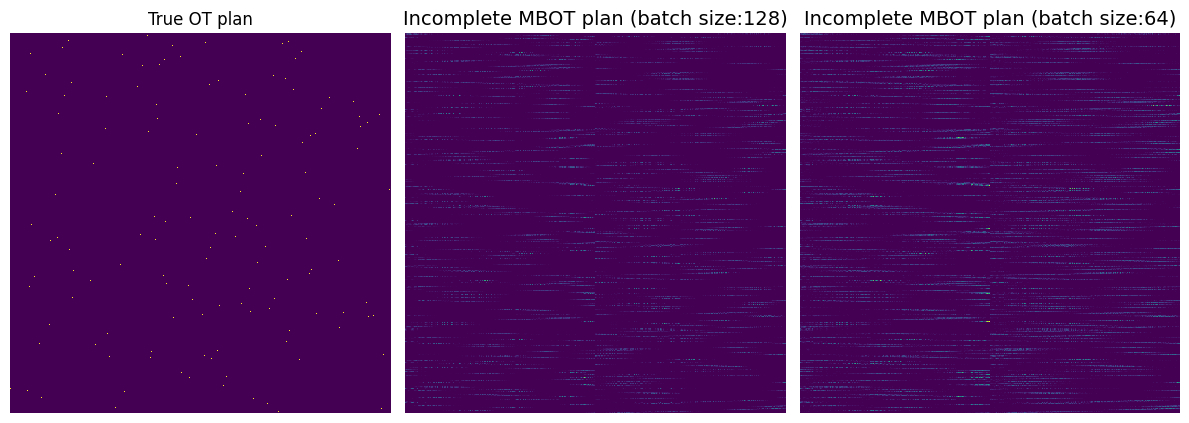

In [10]:
pl.figure(figsize=(12, 5))

for i in range(3):
    pl.subplot(1, 3, i + 1)
    pl.imshow(ot_plan_list[i], interpolation="nearest")
    pl.axis("off")
    if i == 0:
        pl.title("True OT plan")
    else:
        batch_size = batch_size_list[i - 1]
        pl.title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)
    pl.tight_layout()

从结果可以明显看出，小批量近似会导致传输方案变得更加稠密——随着批量尺寸减小，样本间的连接数量会相应增加。此外，当小批量尺寸较小时，这些连接强度往往会趋于均匀分布。在极端情况下，当小批量尺寸为$1$时，小批量最优传输方案将退化为均匀分布。这正是小批量近似可能导致我们推理过程中的流形轨迹变得弯曲的原因。

# 5. 使用不同OT方案训练OT-CFM模型

既然我们已经了解如何定义小批量OT方案，现在可以比较它们对我们OT-CFM方法的不同影响。我们将使用以下三种方案训练OT-CFM模型：
1. 精确OT方案
2. 小批量尺寸为128的MBOT方案  
3. 小批量尺寸为64的MBOT方案

20000: loss 0.028 time 649.75
20000: loss 0.377 time 509.17


<timed exec>:68: UserWarning: The figure layout has changed to tight


20000: loss 0.534 time 523.27
CPU times: user 37min 54s, sys: 6min 30s, total: 44min 24s
Wall time: 28min 6s


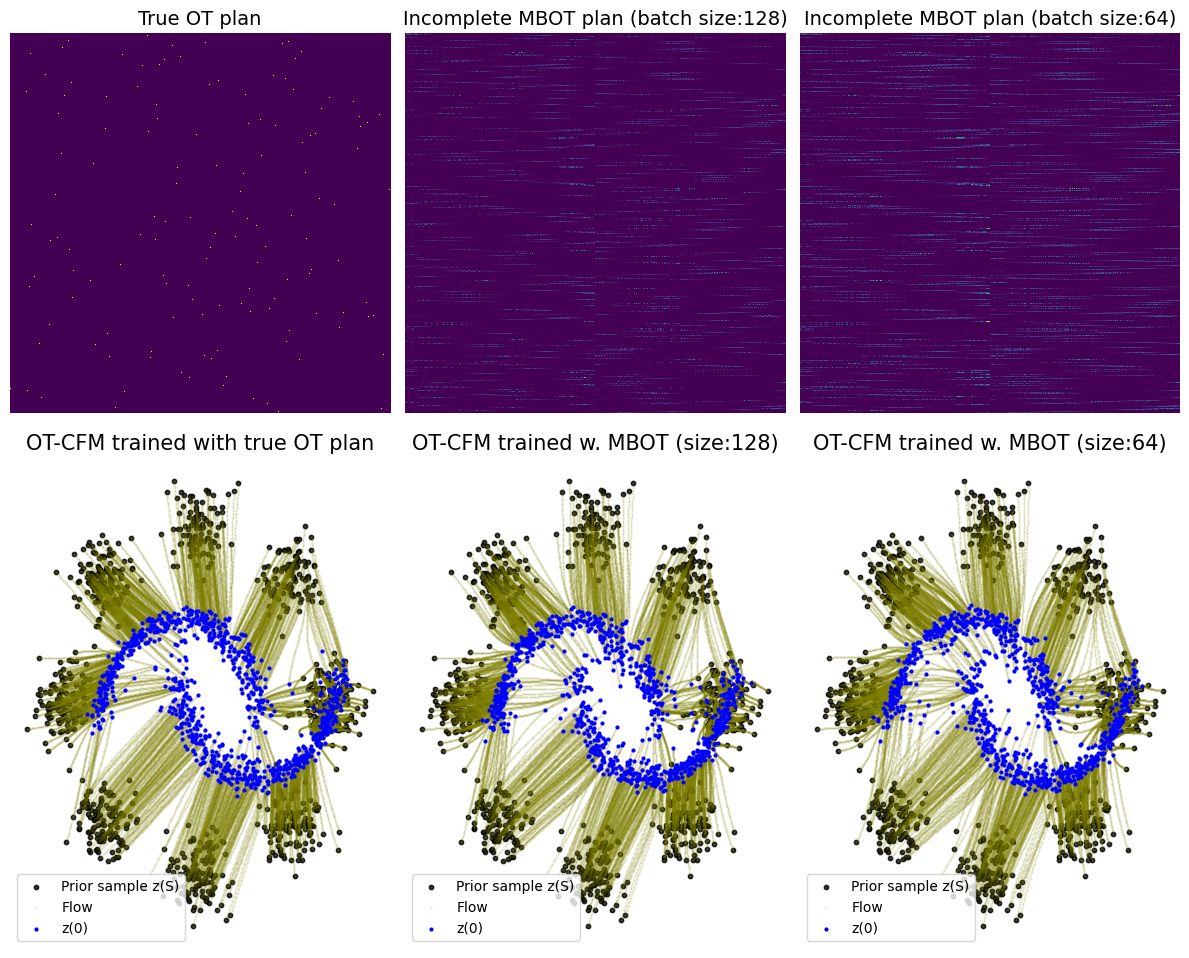

In [11]:
%%time
sigma = 0.1
dim = 2
pl.figure(3, figsize=(12, 10))
batch_size = 128

for i, mbot_plan in enumerate(ot_plan_list):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="exact")

    start = time.time()
    for k in range(20000):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(
            mbot_plan, batch_size=batch_size, replace=False
        )
        batch_x0, batch_x1 = x0[indices_i], x1[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    end = time.time()
    print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
    start = end
    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            x0,
            t_span=torch.linspace(0, 1, 100),
        )

        pl.subplot(2, 3, i + 1)
        pl.imshow(ot_plan_list[i], interpolation="nearest")
        pl.axis("off")
        if i == 0:
            pl.title("True OT plan", fontsize=14)
        else:
            batch_size = batch_size_list[i - 1]
            pl.title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        plt.scatter(
            traj[0, :total_sample, 0], traj[0, :total_sample, 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :total_sample, 0], traj[:, :total_sample, 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :total_sample, 0], traj[-1, :total_sample, 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        pl.axis("off")
        if i == 0:
            pl.title("OT-CFM trained with true OT plan", fontsize=15)
        else:
            pl.title("OT-CFM trained w. MBOT (size:{})".format(batch_size), fontsize=15)
        pl.tight_layout()
# pl.savefig('OT_CFM_different_MBOT_plan.png')

有趣的是，在这个二维示例中，即使使用较小的小批量尺寸，基于小批量最优传输方案训练的OT-CFM模型也能产生笔直的流动轨迹。我们在Cifar10数据集上的实验进一步支持了这一观察结果：与I-CFM相比，使用该方法只需更少的推理步骤就能获得具有竞争力的FID分数。

尽管作为一种近似方法，小批量最优传输已被证明是一种高效的技术，并在多种机器学习任务中获得了广泛应用。早期关于[生成对抗网络](https://proceedings.mlr.press/v84/genevay18a.html)和[领域自适应](https://arxiv.org/abs/1803.10081)的研究都曾采用小批量最优传输方法。

## 5.1 SB-CFM：基于熵正则化最优传输训练的OT-CFM模型

在接下来的部分中，我们将使用熵正则化最优传输方案来训练OT-CFM模型。该EOT方案是以下优化问题的解：

$$\Pi_{\varepsilon} = \text{argmin}_{\Pi \in U(\alpha, \beta)} \langle \Pi, C \rangle - \varepsilon H(\Pi),$$

其中$H$表示熵函数。关于熵正则化最优传输问题的完整讨论，我们建议读者参考[(Peyré et al., chapter 4)](https://arxiv.org/abs/1803.00567)。

采用熵正则化OT方案而非精确OT方案的动机在于其与薛定谔桥问题的内在联系。薛定谔桥问题旨在寻找给定参考过程下源分布与目标分布之间最可能的演化路径，该问题近期在机器学习领域受到广泛关注[(de Bortoli et al.)](https://arxiv.org/abs/2106.01357)。当使用$\Pi_\varepsilon$训练OT-CFM时，该方法与薛定谔桥问题的概率流完全吻合。

我们将评估不同强度的熵正则化OT方案对OT-CFM方法推理效果的影响，具体探索三种正则化强度：$\varepsilon=\{1, 10, 100\}$。

/tmp/ipykernel_19/3526569599.py:19: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


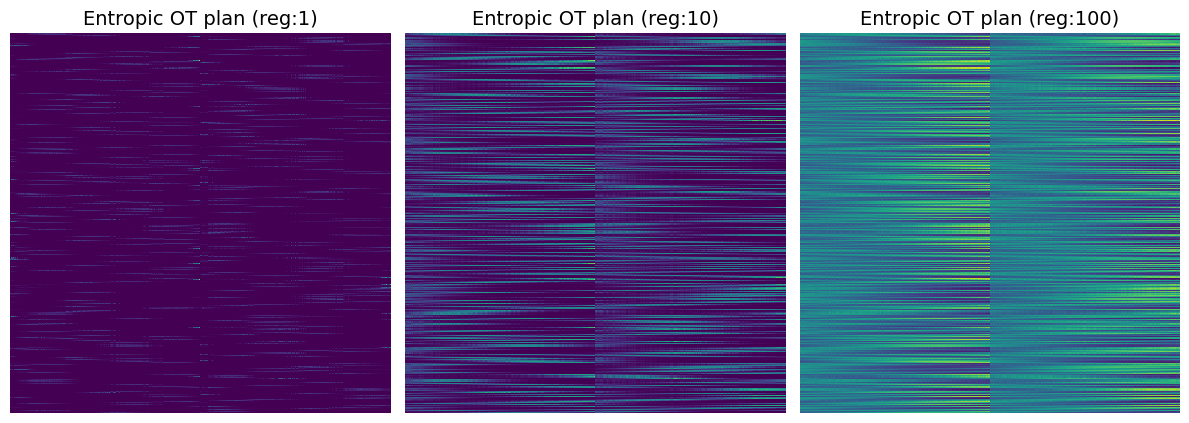

In [12]:
reg_list = [1, 10, 100]

pl.figure(3, figsize=(12, 5))

x0 = sample_8gaussians(1000)
x1 = sample_moons(1000)

ot_plan_list = []

for i, reg in enumerate(reg_list):
    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    entropic_ot_plan = ot_sampler.get_map(x0, x1)
    ot_plan_list.append(entropic_ot_plan)
    pl.subplot(1, 3, i + 1)
    pl.imshow(entropic_ot_plan, interpolation="nearest")
    pl.axis("off")
    pl.title("Entropic OT plan (reg:{})".format(reg), fontsize=14)
    pl.tight_layout()

当采用较小的正则化系数$\varepsilon$时，传输方案会非常接近真实的最优传输方案，因此SB-CFM的行为特性将与OT-CFM基本一致。然而随着正则化系数的增大，熵正则化最优传输方案会逐渐收敛至均匀传输方案。在这种情况下，我们的方法实质上将退化为独立条件流匹配方法。

20000: loss 0.327 time 372.92
20000: loss 2.616 time 369.46


<timed exec>:62: UserWarning: The figure layout has changed to tight


20000: loss 9.027 time 363.72
CPU times: user 34min 36s, sys: 4.81 s, total: 34min 41s
Wall time: 18min 39s


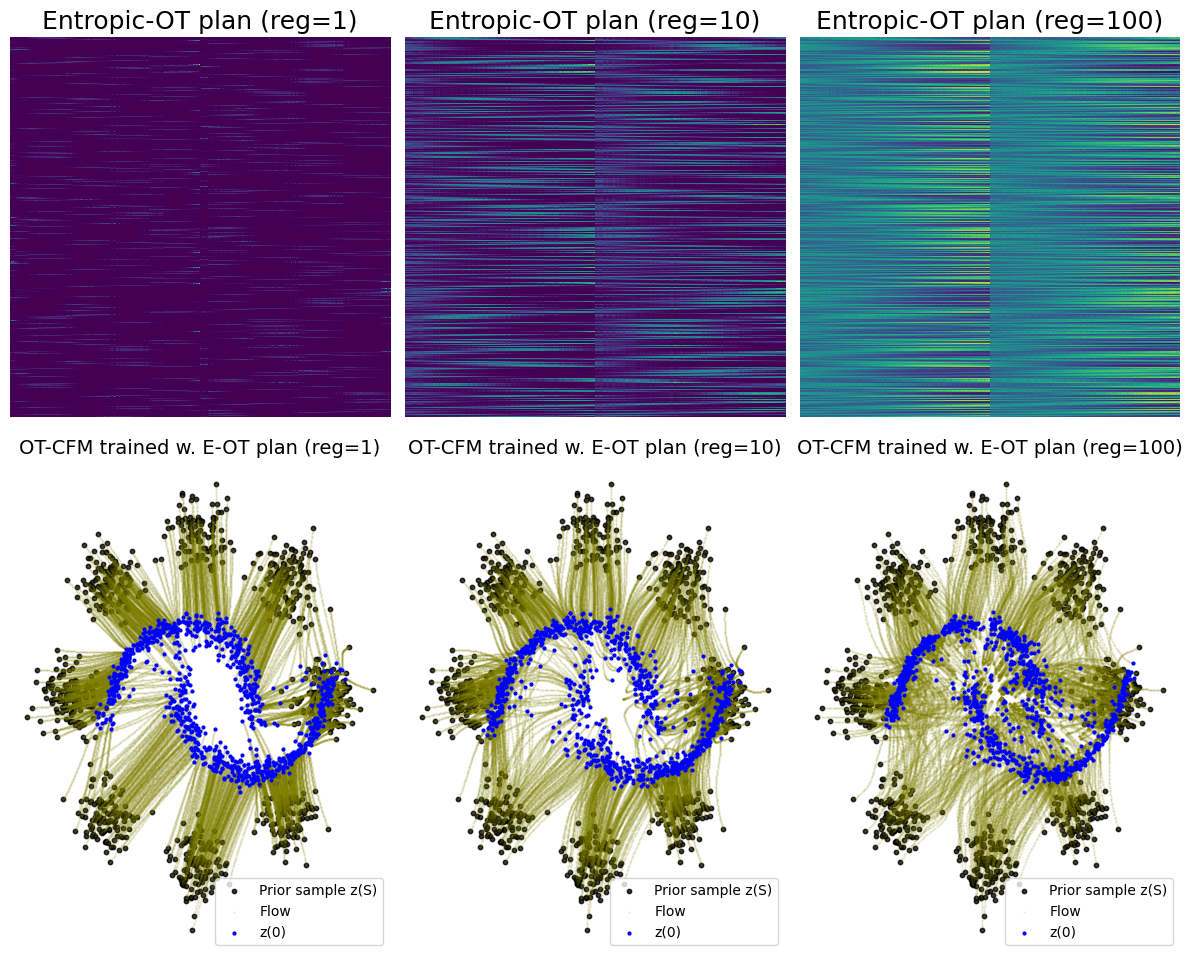

In [13]:
%%time
total_sample = 1000
sigma = 0.1
dim = 2
batch_size = 128

pl.figure(3, figsize=(12, 10))

for i, reg in enumerate(reg_list):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    pi = ot_sampler.get_map(x0, x1)

    start = time.time()
    for k in range(20000):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(pi, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = x0[indices_i], x1[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    end = time.time()
    print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
    start = end
    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            x0,
            t_span=torch.linspace(0, 1, 100),
        )
        pl.subplot(2, 3, i + 1)
        pl.imshow(ot_plan_list[i], interpolation="nearest")
        pl.axis("off")
        pl.title("Entropic-OT plan (reg={})".format(reg), fontsize=18)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        plt.scatter(
            traj[0, :total_sample, 0], traj[0, :total_sample, 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :total_sample, 0], traj[:, :total_sample, 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :total_sample, 0], traj[-1, :total_sample, 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        pl.axis("off")
        pl.title("OT-CFM trained w. E-OT plan (reg={})".format(reg), fontsize=14)
        pl.tight_layout()
pl.savefig("OT_CFM_different_entropic_OT_plan.png")

正如预期所示，当我们选择较小的正则化参数$\varepsilon$时，获得的传输方案与真实最优传输方案高度吻合，从而产生与OT-CFM类似的笔直流轨迹。然而当$\varepsilon \to \infty$时，传输矩阵会退化为均匀矩阵，导致SB-CFM的流轨迹逐渐收敛至I-CFM的流轨迹。

# 6.熵正则化小批量最优传输

通过本笔记的持续观察，我们发现熵正则化最优传输和小批量最优传输对传输方案会产生相似的影响：它们都会增加源样本与目标样本之间的连接数量。若将熵正则化最优传输与小批量最优传输结合使用，会导致传输方案过度稠密，从而更快地退化为I-CFM方案。在我们的实验过程中，我们观察到采用精确最优传输的小批量方法比结合熵正则化的小批量最优传输能产生更优的结果。因此，我们建议采用无熵正则化的小批量最优传输计算方法。